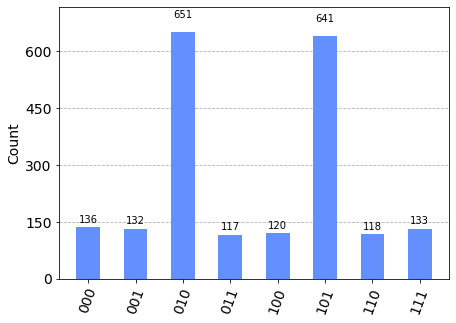

In [71]:
'''
(C) Renata Wong (NCTS-NTU) 2023

This is the accompanying code for the paper "Quantum speedup for the maximum cut problem"
for the example graph given in Fig. 1.
'''

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import numpy as np

'''
Create the quantum circuit for the 3-vertex example
num_vertices = n = number of vertices
num_enges = m = number of edges

'''


'''
PLEASE FILL IN THE EDGE LIST FOR YOUR GRAPH IN THE LINE BELOW
'''
permanent_edge_list = [[0,1], [1,2]]



num_vertices = len({x for l in permanent_edge_list for x in l})
num_edges = len(permanent_edge_list)

range_z = (((num_edges + 1) * (num_edges + 2)) / 2) - 1   
range_r = 4 * (num_edges * (num_edges + 1)) / 2 
range_s = 2 * (num_edges * (num_edges + 1)) / 2   

aux = QuantumRegister(1, 'aux')
z_reg = QuantumRegister(range_z, 'z_reg')
s_reg = QuantumRegister(range_s, 's_reg')
r_reg = QuantumRegister(range_r, 'r_reg')
x_reg = QuantumRegister(num_vertices, 'x_reg')
readout = ClassicalRegister(num_vertices, 'out')
qc = QuantumCircuit(aux, x_reg, r_reg, s_reg, z_reg, readout)

qc.x(aux)
qc.h(aux)

system_size = qc.num_qubits




'''
Create z_matrix to store elements of z_reg
'''

z_matrix = [ [ 0 for i in range(num_edges + 1) ] for j in range(num_edges + 1) ]
zij = 0
for i in range(1, num_edges + 1):
    for j in range(i + 1):
        z_matrix[i][j] = zij
        zij += 1

        



'''
Define the CFE subcircuit
'''

sq = QuantumRegister(10,'sq')     
sc = QuantumCircuit(sq, name='CFE')

# EIIAC
sc.x(sq[1])
sc.ccx(sq[0], sq[1], sq[2])
sc.x(sq[0])
sc.x(sq[1])
sc.ccx(sq[0], sq[1], sq[3])
sc.x(sq[0])
sc.x(sq[2])
sc.x(sq[3])
sc.ccx(sq[2], sq[3], sq[6])
sc.x(sq[2])
sc.x(sq[3])
    
# EINIAC
sc.x(sq[0])
sc.x(sq[1])
sc.ccx(sq[0], sq[1], sq[4])
sc.x(sq[0])
sc.x(sq[1])
sc.ccx(sq[0], sq[1], sq[5])
sc.x(sq[4])
sc.x(sq[5])
sc.ccx(sq[4], sq[5], sq[7])
sc.x(sq[4])
sc.x(sq[5])

# CNOTS
sc.cx(sq[6], sq[9])
sc.cx(sq[7], sq[8])
    
cfe = sc.to_instruction()





'''
Define the CSE subcircuit
'''

cq = QuantumRegister(11,'cq')     
ce = QuantumCircuit(cq, name='CSE')

# EIIAC
ce.x(cq[1])
ce.ccx(cq[0], cq[1], cq[2])
ce.x(cq[0])
ce.x(cq[1])
ce.ccx(cq[0], cq[1], cq[3])
ce.x(cq[0])
ce.x(cq[2])
ce.x(cq[3])
ce.ccx(cq[2], cq[3], cq[6])
ce.x(cq[2])
ce.x(cq[3])

# EINIAC
ce.x(cq[0])
ce.x(cq[1])
ce.ccx(cq[0], cq[1], cq[4])
ce.x(cq[0])
ce.x(cq[1])
ce.ccx(cq[0], cq[1], cq[5])
ce.x(cq[4])
ce.x(cq[5])
ce.ccx(cq[4], cq[5], cq[7])
ce.x(cq[4])
ce.x(cq[5])

# CNOTS
ce.ccx(cq[6], cq[8], cq[9])
ce.ccx(cq[7], cq[8], cq[10])

cse = ce.to_instruction()

    

    
    
'''
Initialize the system and set it in a uniform superpostion   -> lines 1 and 2 of Algorithm 1 in paper
'''

for qubit in s_reg:
    qc.x(qubit)

for qubit in x_reg:
    qc.h(qubit)
    
qc.barrier()






'''
NOTE: There will always be an even number of solutions, since under maximum cut 101 is the same as 010.
For Fig. 1 in the paper, we set the number of solutions to 2.

YOU MAY NEED TO ADJUST THE NUMBER OF SOLUTIONS.
'''

num_solutions = 2   
num_runs = int(np.ceil(np.pi * np.sqrt((2**num_vertices) / num_solutions)) / 4)




'''
Amplitude amplification
'''    

for run in range(num_runs):

    # Apply CFE to |psi_1>   -> line 3 in Algorithm 1
    # It is assumed that the two vertices in the x_reg share an edge
    
    r = 4   
    s = 2
    
    edge_list = permanent_edge_list.copy()

    if len(edge_list) > 0:
        
        index_v1 = edge_list[0][0]
        index_v2 = edge_list[0][1]
        edge_list.pop(0)
        
        cfe_qubits = []
        cfe_qubits += [x_reg[index_v1]]
        cfe_qubits += [x_reg[index_v2]]
        cfe_qubits += [r_reg[i] for i in range(4)]
        cfe_qubits += [s_reg[i] for i in range(2)]
        cfe_qubits += [z_reg[i] for i in range(2)] 
        qc.append(cfe, cfe_qubits)



    # Apply CSE to |psi_2>   --> line 4 in Algorithm 1
    # It is assumed that the two vertices in the x_reg share an edge

    for i in range(1, num_edges):
        
        index_v1 = edge_list[0][0]
        index_v2 = edge_list[0][1]
        
        cse_qubits = []
        for j in reversed(range(i+1)):
            cse_qubits += [x_reg[index_v1]]
            cse_qubits += [x_reg[index_v2]]
            cse_qubits += [r_reg[i] for i in range(r, r+4)]
            cse_qubits += [s_reg[i] for i in range(s, s+2)]
            cse_qubits += [z_reg[z_matrix[i][j]]]                     
            cse_qubits += [z_reg[z_matrix[i+1][j+1]]]                 
            cse_qubits += [z_reg[z_matrix[i+1][j]]]                     
            qc.append(cse, cse_qubits)
            cse_qubits.clear()
            r += 4
            s += 2
            
        edge_list.pop(0)
            
   



    '''
    Which qubit of register z_reg is used here depends on how many edges are there in the cut.
    For the example in Fig. 1 we expect 2 edges, and therefore we choose qubit 2 (counting from 0, 1, 2, etc.).
    This qubit should be in the state 1.
    
    YOU MAY NEED TO ADJUST THE CONTROL QUBIT IN THE CX GATE.
    '''
    
    qc.barrier()
    qc.h(aux)
    qc.cx(z_reg[len(z_reg)-1], aux)
    qc.h(aux)
    qc.barrier()
    
    
    
    

    '''
    Uncompute CSE and CFE operations
    '''

    edge_list = permanent_edge_list.copy()
    
    for i in range(1, num_edges):

        index_v1 = edge_list[len(edge_list) - 1][0]
        index_v2 = edge_list[len(edge_list) - 1][1]

        
        
        cse_qubits = []
        for j in reversed(range(i+1)):
            r -= 4
            s -= 2
            cse_qubits += [x_reg[index_v1]]
            cse_qubits += [x_reg[index_v2]]
            cse_qubits += [r_reg[i] for i in range(r, r+4)]
            cse_qubits += [s_reg[i] for i in range(s, s+2)]
            cse_qubits += [z_reg[z_matrix[i][j]]]                
            cse_qubits += [z_reg[z_matrix[i+1][j+1]]]                   
            cse_qubits += [z_reg[z_matrix[i+1][j]]]                      
            qc.append(cse.inverse(), cse_qubits)
            cse_qubits.clear()

        edge_list.pop(0)

    

    
    edge_list = [permanent_edge_list[0]]
    
    if len(edge_list) > 0:
        
        index_v1 = edge_list[0][0]
        index_v2 = edge_list[0][1]
        
        cfe_qubits = []
        cfe_qubits += [x_reg[index_v1]]
        cfe_qubits += [x_reg[index_v2]]
        cfe_qubits += [r_reg[i] for i in range(4)]
        cfe_qubits += [s_reg[i] for i in range(2)]
        cfe_qubits += [z_reg[i] for i in range(2)] 
        qc.append(cfe.inverse(), cfe_qubits)   
    
        edge_list.pop()
    
    
    
    
    '''
    Diffusion operations
    '''

    qc.barrier()
    
    for qubit in x_reg:
        qc.h(qubit)
        qc.x(qubit)
        
    # apply CZ to aux
    qc.h(aux)
    qc.mcx(x_reg, aux)
    qc.h(aux)
    
    for qubit in x_reg:
        qc.x(qubit)
        qc.h(qubit)

    qc.barrier()
            

        
        
        
            
'''
Measurement 
'''

cuts = []

for i in range(len(x_reg)):
    cuts.append(x_reg[i])

# Reverse the order in which the output is shown so that it can be read from left to right.
cuts.reverse()


qc.measure(cuts, readout)

from qiskit import Aer, execute
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator
simulator = Aer.get_backend('qasm_simulator')
result = execute(qc, backend = simulator, shots = 2048).result()
counts = result.get_counts()


# Uncomment to save the output
#plot_histogram(counts).savefig('example.svg')
plot_histogram(counts)

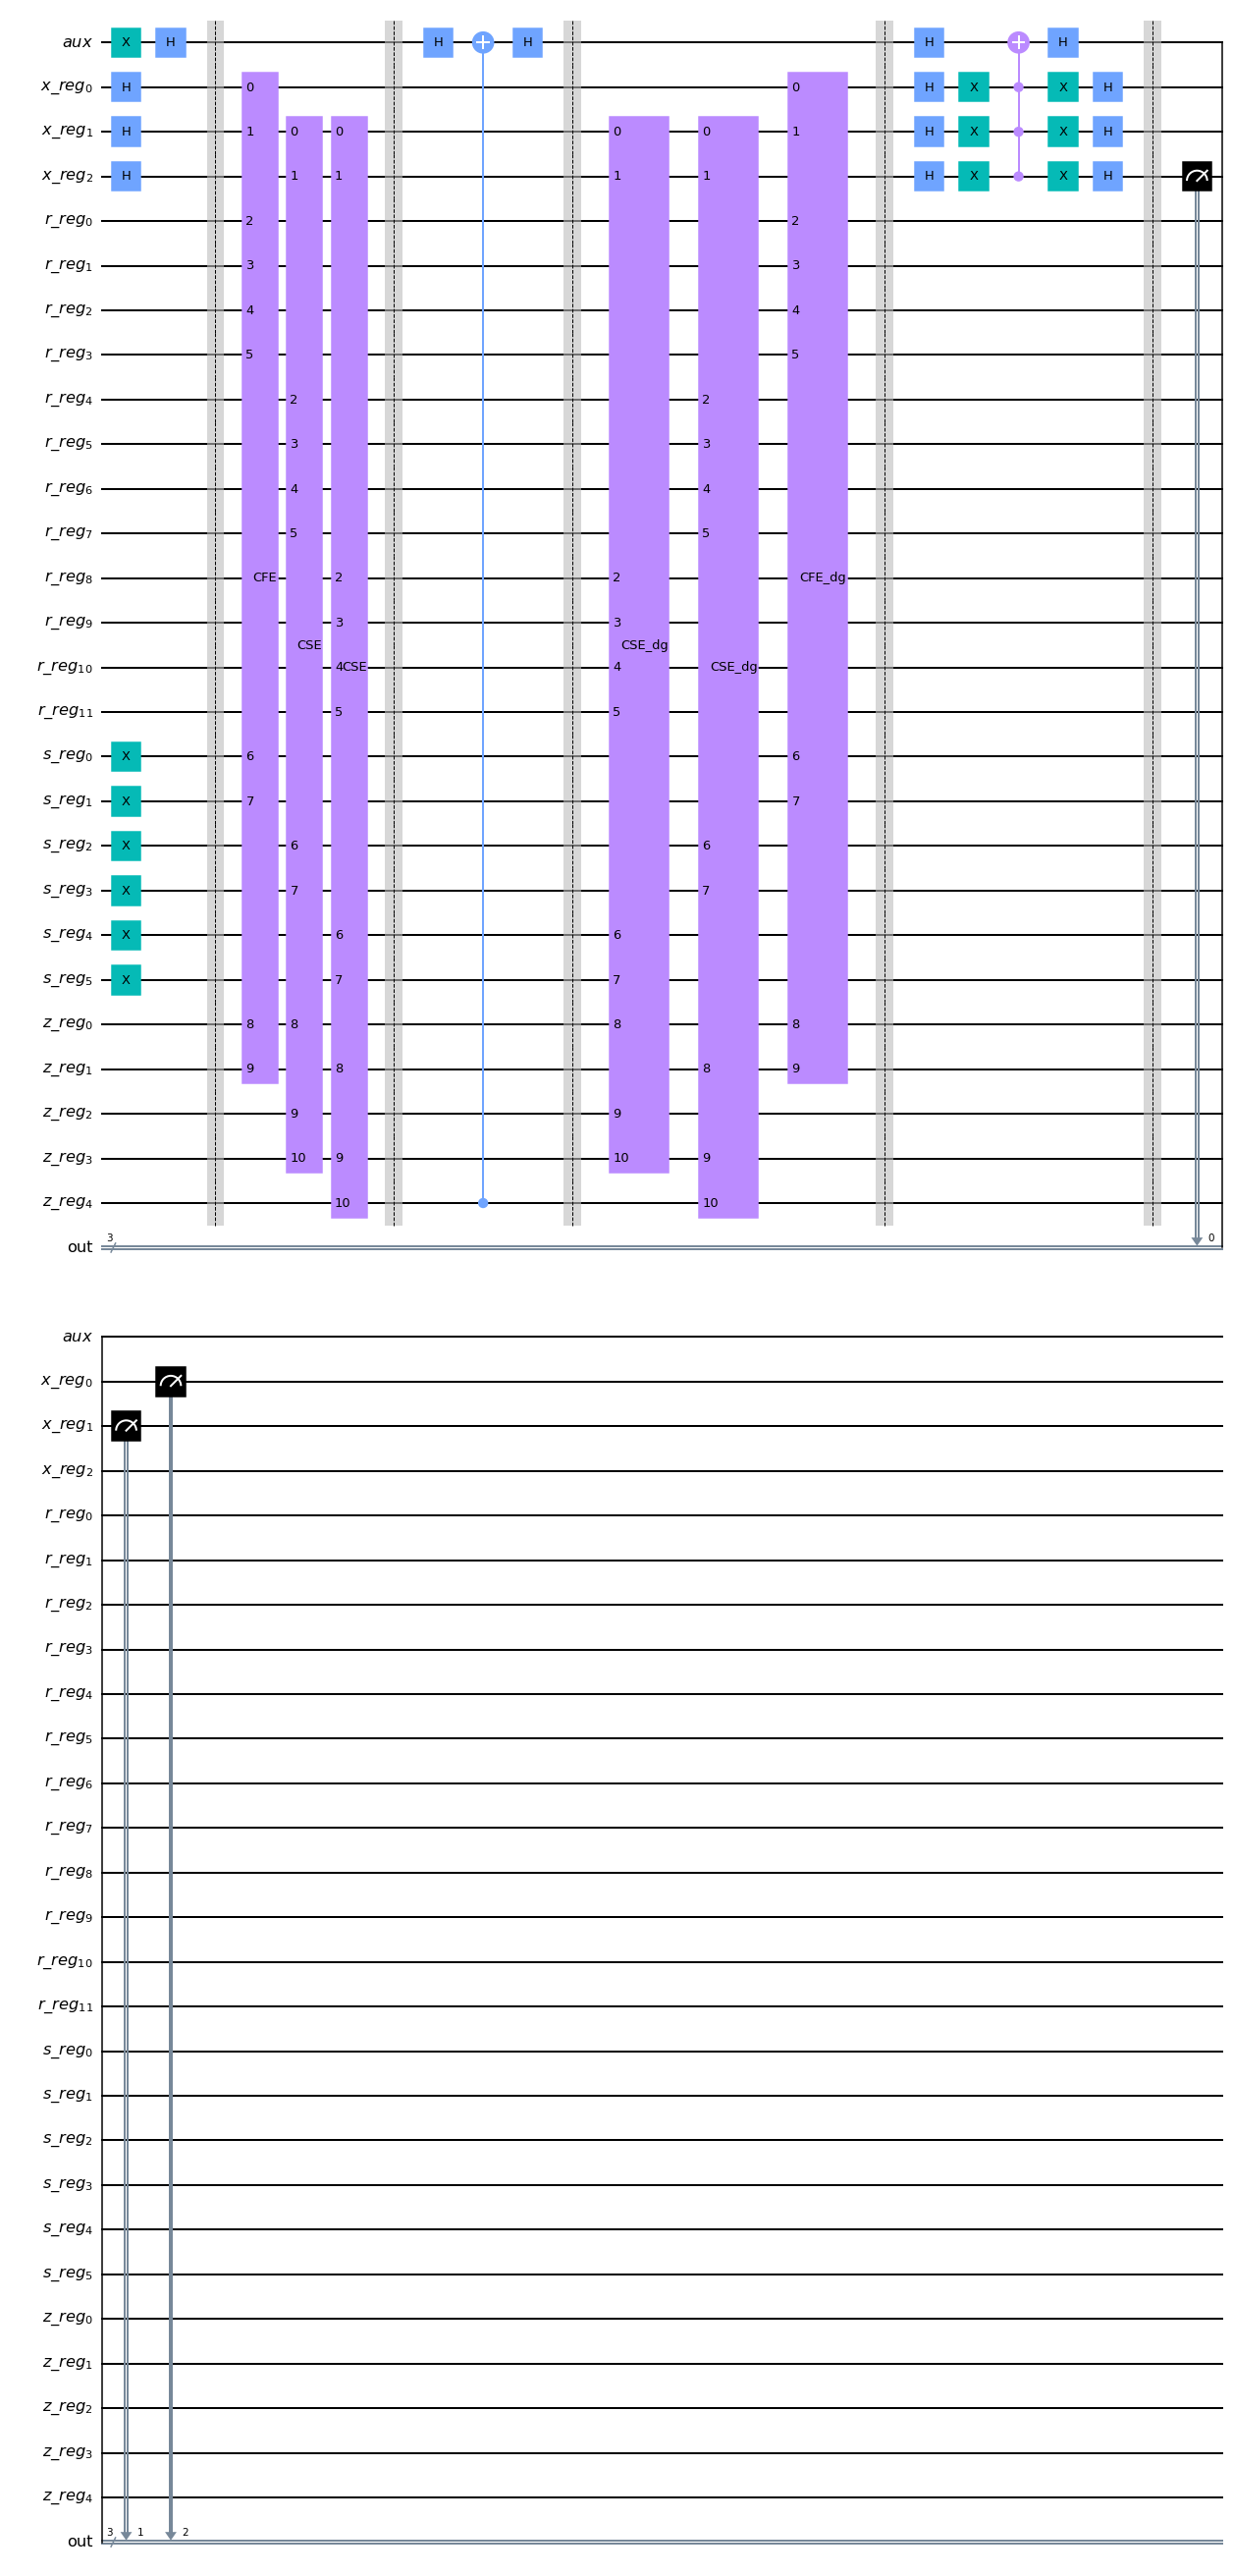

In [68]:
# See the produced circuit
qc.draw('mpl')